# Using Autobounds to solve discrete problems

In [15]:
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore')

## Creating the model

### Setting the DAG

In this example, we're going to use the same causal graph used in Balke and Pearl's paper. The only difference is that we will generate our own data.

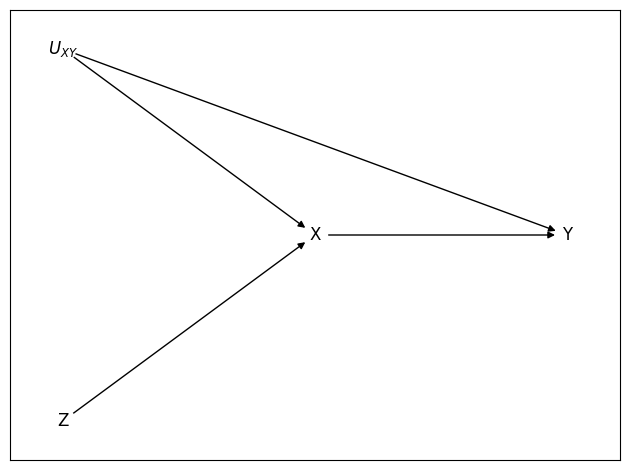

In [16]:
dag = DAG()
dag.from_structure(edges="Z -> X, X -> Y, Uxy -> X, Uxy -> Y", unob = "Uxy")
dag.plot()

### Generating the data

At first, only $Z$ will be ternary and the rest of the variables will remain binary.

In [17]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
n = 1000

# Generate data for exogenous variables Z and U
Z = np.random.choice([0, 1, 2], size=n, p=[0.3, 0.5, 0.2])  # Discrete with 3 values
U = np.random.choice([0, 1], size=n, p=[0.6, 0.4])          # Binary variable

# Generate X as a function of Z and U (binary)
X = np.zeros(n, dtype=int)
# Define P(X=1 | Z, U)
prob_X_given_Z_U = np.array([
    [0.1, 0.7],   # P(X=1 | Z=0, U=0), P(X=1 | Z=0, U=1)
    [0.4, 0.8],   # P(X=1 | Z=1, U=0), P(X=1 | Z=1, U=1)
    [0.9, 0.95]   # P(X=1 | Z=2, U=0), P(X=1 | Z=2, U=1)
])

for i in range(n):
    Z_i, U_i = Z[i], U[i]
    p_X = prob_X_given_Z_U[Z_i, U_i]
    X[i] = np.random.choice([0, 1], p=[1 - p_X, p_X])

# Generate Y as a function of X and U (binary)
Y = np.zeros(n, dtype=int)
# Define P(Y=1 | X, U)
prob_Y_given_X_U = np.array([
    [0.3, 0.6],   # P(Y=1 | X=0, U=0), P(Y=1 | X=0, U=1)
    [0.7, 0.9]    # P(Y=1 | X=1, U=0), P(Y=1 | X=1, U=1)
])

for i in range(n):
    X_i, U_i = X[i], U[i]
    p_Y = prob_Y_given_X_U[X_i, U_i]
    Y[i] = np.random.choice([0, 1], p=[1 - p_Y, p_Y])

# Create a DataFrame to store the generated data
data = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})

# Display the first few rows of the generated data
data.head()


,Z,X,Y
0,1,0,0
1,2,1,1
2,1,1,1
3,1,1,1
4,0,0,1


### Computing probabilities for each strata of the population

Since we have 2 binary observable variables and 1 ternary observable variable, we have 12 ($3\cdot2^2$) possible strata for our population. In the Data Frame below, we will calculate the empirical probability for each of them, i.e., $P(Z=z, X=x, Y=y)$.

In [18]:
# group individuals into strata
dat = pd.DataFrame(data.groupby(['Z', 'X', 'Y']).value_counts().reset_index()) 
dat['prob'] = dat['count'] / dat['count'].sum()
dat = dat.drop(columns='count', axis=0)
dat

,Z,X,Y,prob
0,0,0,0,0.140
1,0,0,1,0.075
2,0,1,0,0.018
3,0,1,1,0.086
4,1,0,0,0.142
5,1,0,1,0.068
6,1,1,0,0.059
7,1,1,1,0.213
8,2,0,0,0.007
9,2,0,1,0.003


### Defining the problem

When creating our causal problem, we need to specify which variables are not binary and their actual cardinalities using the `number_values` parameter inside the `causalProblem` class.

In [19]:
problem = causalProblem(dag, {'Z':3})
problem.load_data(dat)

### Adding the constraints for the optimization problem

In [20]:
problem.add_prob_constraints()

### Calculating the ATE

In [21]:
problem.set_ate(ind="X", dep="Y")
prog_ate = problem.write_program()


# run optimisation routine, argument saves results at filename
prog_ate_optim = prog_ate.run_scip('replication_files/results/BalkePearl.csv')

print("==============================================")
print(f"Causal effect lies in the interval [{np.round(prog_ate_optim[0]['dual'], 3)}, "
      f"{np.round(prog_ate_optim[1]['dual'], 3)}]" 
)

[('Z0', 0.319), ('Z1', 0.482), ('Z2', 0.199)]
LOWER BOUND: # -- Primal: 0.1926403 / Dual: 0.1926403 / Time: 0.0 ##
UPPER BOUND: # -- Primal: 0.5689104 / Dual: 0.5689104 / Time: 0.0 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 0.37627010000000005 / Epsilon: 0.0 ##
Causal effect lies in the interval [0.193, 0.569]


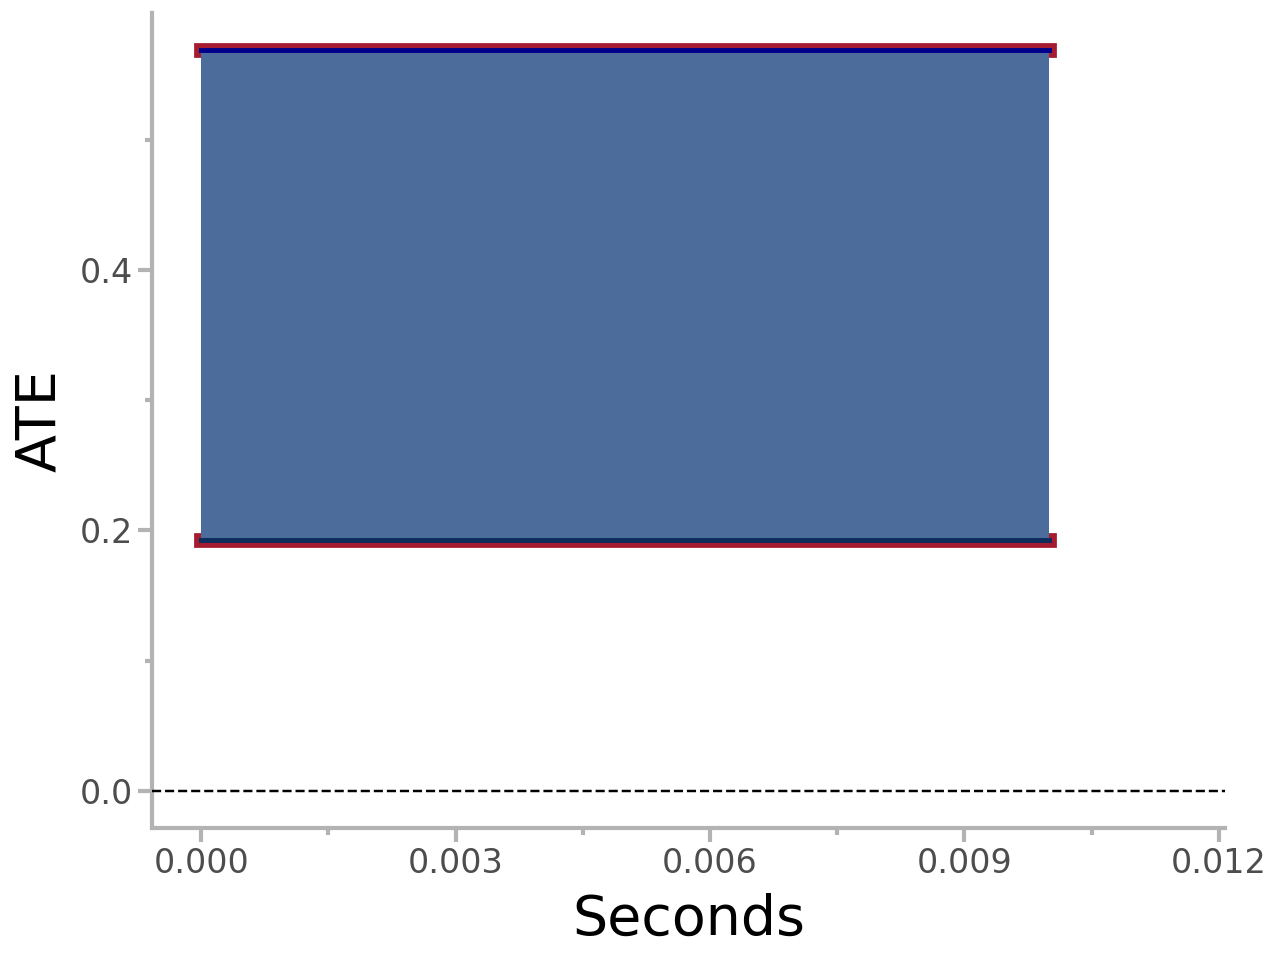

In [22]:
prog_ate.plot()

The actual value of the ATE is 0.36, since
$$ \mathbb{P}(Y=y | do(X=x)) = \sum_u \mathbb{P}(Y = y | X=x, U=u)\mathbb{P}(U=u) $$
we get
$$ \mathbb{P}(Y=1 | do(X=1)) = \mathbb{P}(Y = 1 | X=1, U=1)\mathbb{P}(U=1) + \mathbb{P}(Y = 1 | X=1, U=0)\mathbb{P}(U=0) = (0.9)(0.4) + (0.7)(0.6) = 0.78 $$
$$ \mathbb{P}(Y=1 | do(X=0)) = \mathbb{P}(Y = 1 | X=0, U=1)\mathbb{P}(U=1) + \mathbb{P}(Y = 1 | X=0, U=0)\mathbb{P}(U=0) = (0.6)(0.4) + (0.3)(0.6) = 0.42 $$
Now, to calculate the ATE:
$$ ATE = \mathbb{P}(Y=1 | do(X=1)) - \mathbb{P}(Y=1 | do(X=0)) = 0.78- 0.42 = 0.36 $$



Since 0.36 is contained inside the bounds found by the program, we can conclude the results were satisfactory in this example.

## Repeating the same process

At last, in the example below Y will also be ternary.

In [23]:
# Set a random seed for reproducibility
np.random.seed(42)

# Define the number of samples
n = 1000

# Generate data for exogenous variables Z and U
# Z is now a ternary variable (values 0, 1, 2)
Z = np.random.choice([0, 1, 2], size=n, p=[0.3, 0.5, 0.2])  # Adjust probabilities as needed

# U remains a binary variable (values 0, 1)
U = np.random.choice([0, 1], size=n, p=[0.6, 0.4])          # Adjust probabilities as needed

# Generate X as a function of Z and U (binary)
X = np.zeros(n, dtype=int)

# Define P(X=1 | Z, U)
# A 3x2 matrix: rows for Z values (0,1,2), columns for U values (0,1)
prob_X_given_Z_U = np.array([
    [0.2, 0.6],   # P(X=1 | Z=0, U=0), P(X=1 | Z=0, U=1)
    [0.5, 0.7],   # P(X=1 | Z=1, U=0), P(X=1 | Z=1, U=1)
    [0.8, 0.9]    # P(X=1 | Z=2, U=0), P(X=1 | Z=2, U=1)
])

for i in range(n):
    Z_i, U_i = Z[i], U[i]
    p_X = prob_X_given_Z_U[Z_i, U_i]
    X[i] = np.random.choice([0, 1], p=[1 - p_X, p_X])

# Generate Y as a function of X and U (ternary variable)
Y = np.zeros(n, dtype=int)

# Define P(Y=y | X, U), where y ∈ {0, 1, 2}
# A 2x2x3 tensor: X values (0,1), U values (0,1), Y values (0,1,2)
prob_Y_given_X_U = np.array([
    [  # X=0
        [0.6, 0.3, 0.1],  # U=0: P(Y=0 | X=0, U=0), P(Y=1 | X=0, U=0), P(Y=2 | X=0, U=0)
        [0.3, 0.4, 0.3]   # U=1: P(Y=0 | X=0, U=1), P(Y=1 | X=0, U=1), P(Y=2 | X=0, U=1)
    ],
    [  # X=1
        [0.2, 0.5, 0.3],  # U=0: P(Y=0 | X=1, U=0), P(Y=1 | X=1, U=0), P(Y=2 | X=1, U=0)
        [0.1, 0.3, 0.6]   # U=1: P(Y=0 | X=1, U=1), P(Y=1 | X=1, U=1), P(Y=2 | X=1, U=1)
    ]
])

for i in range(n):
    X_i, U_i = X[i], U[i]
    p_Y = prob_Y_given_X_U[X_i, U_i]
    Y[i] = np.random.choice([0, 1, 2], p=p_Y)

# Create a DataFrame to store the generated data
data = pd.DataFrame({'Z': Z, 'X': X, 'Y': Y})

# Display the first few rows of the generated data
data.head()

,Z,X,Y
0,1,0,1
1,2,1,2
2,1,1,1
3,1,0,1
4,0,0,1


Since we have 1 binary observable variable and 2 ternary observable variables, we have 18 ($3^2\cdot2$) possible strata for our population. In the Data Frame below, we will calculate the empirical probability for each of them, i.e., $P(Z=z, X=x, Y=y)$.

In [24]:
dat = pd.DataFrame(data.groupby(['Z', 'X', 'Y']).value_counts().reset_index()) 
dat['prob'] = dat['count'] / dat['count'].sum()
dat = dat.drop(columns='count', axis=0)
dat

,Z,X,Y,prob
0,0,0,0,0.112
1,0,0,1,0.066
2,0,0,2,0.032
3,0,1,0,0.019
4,0,1,1,0.038
5,0,1,2,0.052
6,1,0,0,0.106
7,1,0,1,0.071
8,1,0,2,0.028
9,1,1,0,0.043


In [25]:
problem = causalProblem(dag, {'Z':3, 'Y':3})
problem.load_data(dat)

In [26]:
problem.add_prob_constraints()

Autobounds by default considers that, in summary, $ATE = P(ind=1|dep=1) - P(ind=1|dep=0)$

So, in this case, we will only observe the effect of $X$ on $P(Y=1)$, and not the actual average effect on $Y$. For the latter, we would have to consider $Y$'s possible values (0, 1, 2) and weight our probabilities according to them.

In [27]:
problem.set_ate(ind="X", dep="Y")
prog_ate = problem.write_program()


# run optimisation routine, argument saves results at filename
prog_ate_optim = prog_ate.run_scip('replication_files/results/BalkePearl.csv')

print("==============================================")
print(f"Causal effect lies in the interval [{np.round(prog_ate_optim[0]['dual'], 3)}, "
      f"{np.round(prog_ate_optim[1]['dual'], 3)}]" 
)

[('Z0', 0.319), ('Z1', 0.482), ('Z2', 0.199)]
LOWER BOUND: # -- Primal: -0.1415542 / Dual: -0.1415542 / Time: 0.0 ##
UPPER BOUND: # -- Primal: 0.3106914 / Dual: 0.3106914 / Time: 0.0 ##
Problem is finished! Returning final values
Problem is finished! Returning final values
CURRENT THRESHOLDS: # -- Theta: 0.4522456 / Epsilon: 0.0 ##
Causal effect lies in the interval [-0.142, 0.311]


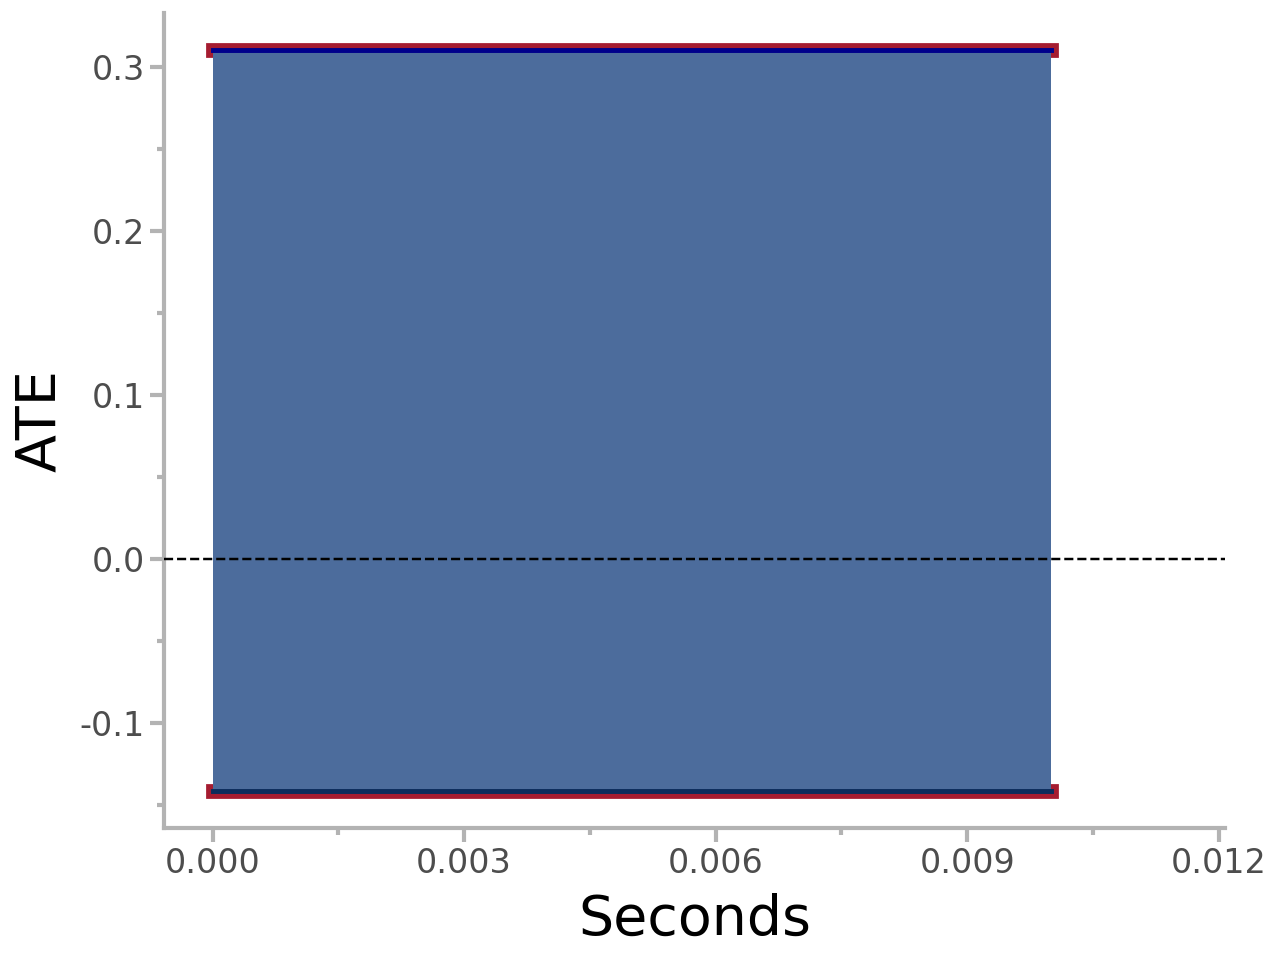

In [28]:
prog_ate.plot()

The actual value of the ATE is 0.08, since
$$ \mathbb{P}(Y=y | do(X=x)) = \sum_u \mathbb{P}(Y = y | X=x, U=u)\mathbb{P}(U=u) $$
we get
$$ \mathbb{P}(Y=1 | do(X=1)) = \mathbb{P}(Y = 1 | X=1, U=1)\mathbb{P}(U=1) + \mathbb{P}(Y = 1 | X=1, U=0)\mathbb{P}(U=0) = (0.3)(0.4) + (0.5)(0.6) = 0.42 $$
$$ \mathbb{P}(Y=1 | do(X=0)) = \mathbb{P}(Y = 1 | X=0, U=1)\mathbb{P}(U=1) + \mathbb{P}(Y = 1 | X=0, U=0)\mathbb{P}(U=0) = (0.4)(0.4) + (0.3)(0.6) = 0.34 $$
Now, to calculate the ATE:
$$ ATE = \mathbb{P}(Y=1 | do(X=1)) - \mathbb{P}(Y=1 | do(X=0)) = 0.42- 0.34 = 0.08 $$



Since 0.08 is contained inside the bounds found by the program, we can conclude the results were satisfactory in this example as well.


## Conclusion 

As the results show, Autobounds supports problems with discrete variables.

The only downside is we're not given the option to calculate the Average Treatment Effect (ATE) using the expected value of $Y$ over its possible values (0, 1, 2), only the probability of Y being 1.